# Stock analysis

## Import

Libraries

In [1]:
from functions.init import *

from functions.analyse_price import *
from functions.analyse_fundementals import *
from functions.params import index_tickers

## Get data

Run data

In [2]:
TICKER = 'NVX'
first_end_of_quarter = '2020-06'
last_end_of_quarter = '2024-06'
historical_prices = {}

In [3]:
asx_companies_directory = pd.read_csv('../data/asx_companies_directory.csv')
asx_companies_directory['Market Cap'] = asx_companies_directory['Market Cap'].apply(
    lambda x: float(x) if x.isnumeric() else float(x.lower()) if 'E+' in x else np.nan)

In [4]:
gics = pd.read_csv('../data/asx_gics.csv')

# Define a dictionary mapping tickers to their corresponding sector and industry
updates = {
    'NWSLV.AX': {'Sector': 'Communication Services', 'Industry': 'Entertainment'},
    'KKC.AX': {'Sector': 'Financials', 'Industry': 'Diversified Financials'},
    'PCI.AX': {'Sector': 'Financials', 'Industry': 'Diversified Financials'},
    'RF1.AX': {'Sector': 'Financials', 'Industry': 'Investment Management'},
    'RG8.AX': {'Sector': 'Information Technology', 'Industry': 'Software'},
    'VG1.AX': {'Sector': 'Financials', 'Industry': 'Investment Management'},
    'WQG.AX': {'Sector': 'Financials', 'Industry': 'Investment Management'}
}

# Update the DataFrame based on the mapping
for ticker, data in updates.items():
    gics.loc[gics['Ticker'] == ticker, 'Sector'] = data['Sector']
    gics.loc[gics['Ticker'] == ticker, 'Industry'] = data['Industry']


gics['Industry'] = gics['Industry'].apply(lambda x: ''.join(
    str(x).split('-')).replace(' ', '').replace('—', ''))

gics['Sector'] = gics['Sector'].apply(lambda x: ''.join(
    str(x).split('-')).replace(' ', '').replace('—', ''))

In [5]:
# all companies in the top 500
top_500 = asx_companies_directory.sort_values(
    'Market Cap', ascending=False).head(500)['ASX code'].values + '.AX'

# get all companies with market cap above 1 billion
above_1b = asx_companies_directory[asx_companies_directory['Market Cap']
                                   >= 1000000000]['ASX code'].values + '.AX'

In [6]:
def find_similar_type_tickers(gics_type: str, gics_name: str, comparable_universe: list) -> list:
    same_gics_tickers = gics[(gics[gics_type] == gics_name) & (
        gics['Ticker'].isin(comparable_universe))]['Ticker'].values

    return same_gics_tickers

In [7]:
# find same industry stocks
ticker_gics_sector = gics[gics['Ticker'] == f'{TICKER}.AX']['Sector'].values[0]
ticker_gics_industry = gics[gics['Ticker']
                            == f'{TICKER}.AX']['Industry'].values[0]

In [8]:
same_sector_1bn = find_similar_type_tickers(
    gics_type='Sector', gics_name=ticker_gics_sector, comparable_universe=above_1b)
same_industry_1bn = find_similar_type_tickers(
    gics_type='Industry', gics_name=ticker_gics_industry, comparable_universe=above_1b)
same_sector_500 = find_similar_type_tickers(
    gics_type='Sector', gics_name=ticker_gics_sector, comparable_universe=top_500)
same_industry_500 = find_similar_type_tickers(
    gics_type='Industry', gics_name=ticker_gics_industry, comparable_universe=top_500)

In [9]:
comparable_tickers = {'type': 'same_industry_500', 'list': same_industry_500} if \
    (len(same_industry_500) > 1 or len(same_industry_500) == 1 and f'{TICKER}.AX' not in same_industry_500) \
    else {'type': 'same_sector_1bn', 'list': same_sector_1bn}

In [10]:
comparable_tickers['type']

'same_sector_1bn'

In [11]:
# get market caps and weight
same_industry_tickers_mcap = asx_companies_directory[((asx_companies_directory['ASX code']+'.AX').isin(
    comparable_tickers['list'])) & (asx_companies_directory['ASX code'] != TICKER)][['ASX code', 'Market Cap']]

# check for is integer
marketsame_industry_tickers_mcap_cap = same_industry_tickers_mcap[same_industry_tickers_mcap['Market Cap'].apply(
    lambda x: isinstance(x, float))]

# get weight
same_industry_tickers_mcap['weight'] = same_industry_tickers_mcap['Market Cap'] / \
    same_industry_tickers_mcap['Market Cap'].sum()

In [12]:
same_industry_tickers_mcap = same_industry_tickers_mcap.sort_values(
    by='Market Cap', ascending=False)
display(same_industry_tickers_mcap)

ticker_mv = asx_companies_directory[asx_companies_directory['ASX code'] == TICKER][[
    'ASX code', 'Market Cap']]
display(ticker_mv)

ticker_proportion_of_market = ticker_mv['Market Cap'].values[0] / \
    same_industry_tickers_mcap['Market Cap'].sum()
print(round(ticker_proportion_of_market, 2))

,ASX code,Market Cap,weight
1723,TCL,4.093633e+10,0.204927
358,BXB,2.640665e+10,0.132192
1493,REH,1.786792e+10,0.089447
1699,SVW,1.746022e+10,0.087406
96,AIA,1.117357e+10,0.055935
1454,QAN,1.089885e+10,0.054560
909,IFT,1.070929e+10,0.053611
123,ALX,7.007527e+09,0.035080
120,ALQ,6.919700e+09,0.034640
1464,QUB,6.914100e+09,0.034612


,ASX code,Market Cap
1274,NVX,357968369.0


0.0


In [13]:
ticker_mv['Market Cap'] = ticker_mv['Market Cap'].apply(
    lambda x: round(x/1e9, 2))
ticker_mv.rename(columns={'Market Cap': 'Market Cap ($bn)'}, inplace=True)

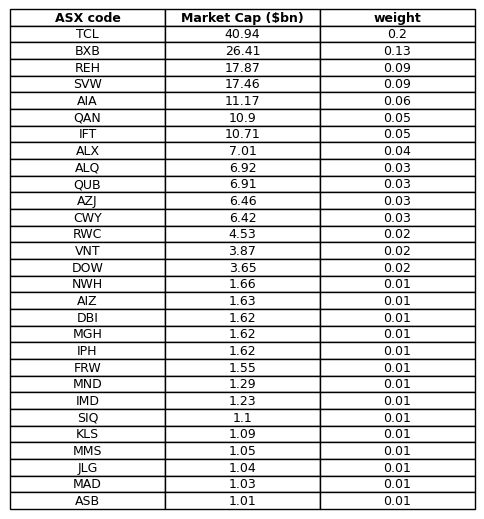

In [14]:
# Create the plot
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust figure size as needed
ax.axis('tight')
ax.axis('off')

same_industry_tickers_mcap['Market Cap'] = same_industry_tickers_mcap['Market Cap'].apply(
    lambda x: round(x/1e9, 2))
same_industry_tickers_mcap.rename(
    columns={'Market Cap': 'Market Cap ($bn)'}, inplace=True)
same_industry_tickers_mcap['weight'] = same_industry_tickers_mcap['weight'].apply(
    lambda x: round(x, 2))


# Create a table in the plot
table = ax.table(cellText=same_industry_tickers_mcap.values,
                 colLabels=same_industry_tickers_mcap.columns,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')


# Save the plot as an image
plt.savefig(f'../outputs/{TICKER}_same_industry_tickers_mcap_table.png',
            bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [15]:
same_gics_industry_weight_dict = same_industry_tickers_mcap.set_index('ASX code')[
    'weight'].to_dict()

In [16]:
# TODO:
my_portfolio_tickers = [TICKER]
my_portfolio_tickers.extend([ticker.split('.')[
                            0] for ticker in comparable_tickers['list'] if ticker.split('.')[0] != TICKER])
my_portfolio_tickers.extend(index_tickers)

historical_prices = get_historical_prices(
    my_portfolio_tickers, index_tickers, historical_prices)

$DBI.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$FRW.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$MGH.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$FRW.AX: possibly delisted; no price data found  (1d 2020-01-01 -> 2020-12-31) (Yahoo error = "Data doesn't exist for startDate = 1577797200, endDate = 1609333200")
$VNT.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$FRW.AX: possibly delisted; no price data found  (1d 2021-01-01 -> 2021-12-31) (Yahoo error = "Data doesn't exist for startDate = 1609419600, endDate = 1640869200")
$VNT.AX: p

In [17]:
monthly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    monthly_returns_df_dict[ticker] = get_return(price_df, 'M')

quarterly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    quarterly_returns_df_dict[ticker] = get_return(price_df, 'Q')

yearly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    yearly_returns_df_dict[ticker] = get_return(price_df, 'Y')

In [18]:
monthly_returns_df_dict = get_gics_industry_weighted_mean(
    monthly_returns_df_dict, TICKER, my_portfolio_tickers, same_gics_industry_weight_dict, index_tickers, 'M', comparable_tickers=comparable_tickers)
quarterly_returns_df_dict = get_gics_industry_weighted_mean(
    quarterly_returns_df_dict, TICKER, my_portfolio_tickers, same_gics_industry_weight_dict, index_tickers, 'Q', comparable_tickers=comparable_tickers)
yearly_returns_df_dict = get_gics_industry_weighted_mean(
    yearly_returns_df_dict, TICKER, my_portfolio_tickers, same_gics_industry_weight_dict, index_tickers, 'Y', comparable_tickers=comparable_tickers)

In [19]:
stats_dict = {}

for ticker in monthly_returns_df_dict:
    stats_dict[ticker] = get_stats(
        monthly_returns_df_dict, ticker, first_end_of_quarter, last_end_of_quarter)

stats_df = pd.DataFrame(stats_dict).T

In [20]:
same_gics_stats_df = stats_df[~stats_df.index.isin(
    index_tickers + [TICKER, 'GICS I.WMean' if 'industry' in comparable_tickers['type'] else 'GICS S.WMean'])]

In [21]:
same_gics_stats_df['ASX code'] = same_gics_stats_df.index

same_gics_stats_df = same_gics_stats_df.merge(
    same_industry_tickers_mcap, on='ASX code')

In [22]:
# get weighted means of each column
weighted_mean_dict = {}
for col in same_gics_stats_df.columns:
    if col in ['ASX code', 'weight']:
        continue
    weighted_mean_dict[col] = np.average(
        same_gics_stats_df[col], weights=same_gics_stats_df['weight'])

weighted_mean_df = pd.DataFrame(weighted_mean_dict, index=[
                                'GICS I.WMean (Macro)' if 'industry' in comparable_tickers['type'] else 'GICS S.WMean (Macro)'])
weighted_mean_df

stats_df = pd.concat(
    [stats_df, weighted_mean_df.drop(columns=['Market Cap ($bn)'])])
stats_df

,mean (%),std (%),n,sharpe,CAPM beta,CAPM alpha
NVX,5.670000,34.510000,49.000000,0.570000,2.320000,4.580000
AIA,0.480000,5.200000,49.000000,0.320000,1.060000,-0.690000
AIZ,-0.450000,8.370000,49.000000,-0.190000,1.830000,-1.490000
ALQ,1.950000,8.220000,49.000000,0.820000,1.450000,1.010000
ALX,0.230000,5.800000,49.000000,0.140000,0.880000,-0.310000
ASB,0.200000,11.000000,49.000000,0.060000,0.870000,0.230000
AZJ,0.080000,5.460000,49.000000,0.050000,0.670000,-0.390000
BXB,0.840000,5.750000,49.000000,0.510000,0.660000,0.740000
CWY,1.220000,8.670000,49.000000,0.490000,1.160000,0.340000
DBI,1.540000,4.220000,42.000000,1.260000,0.450000,1.480000


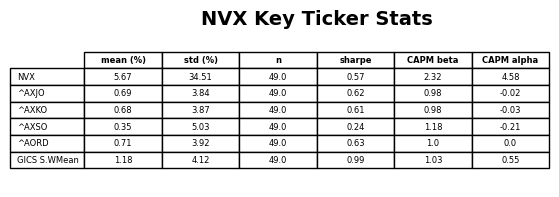

In [23]:
# Assuming key_ticker_stats is already created from your DataFrame
key_ticker_stats = stats_df.loc[[TICKER, '^AXJO',
                                 '^AXKO', '^AXSO', '^AORD'] + ['GICS I.WMean' if 'industry' in comparable_tickers['type'] else 'GICS S.WMean']]

# Create the plot
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=key_ticker_stats.values,
                 colLabels=key_ticker_stats.columns,
                 rowLabels=key_ticker_stats.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Key Ticker Stats", fontsize=14, fontweight='bold')

# Save the plot as an image
plt.savefig(
    f'../outputs/{TICKER}_key_ticker_stats_table.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [24]:
ticker_mv['Market Cap ($bn)'].values[0] / \
    weighted_mean_df['Market Cap ($bn)'].values[0]

0.020531788834870817

In [25]:
correlation_df, period_of_interest_return_df = historical_corr(
    monthly_returns_df_dict, first_end_of_quarter, last_end_of_quarter)

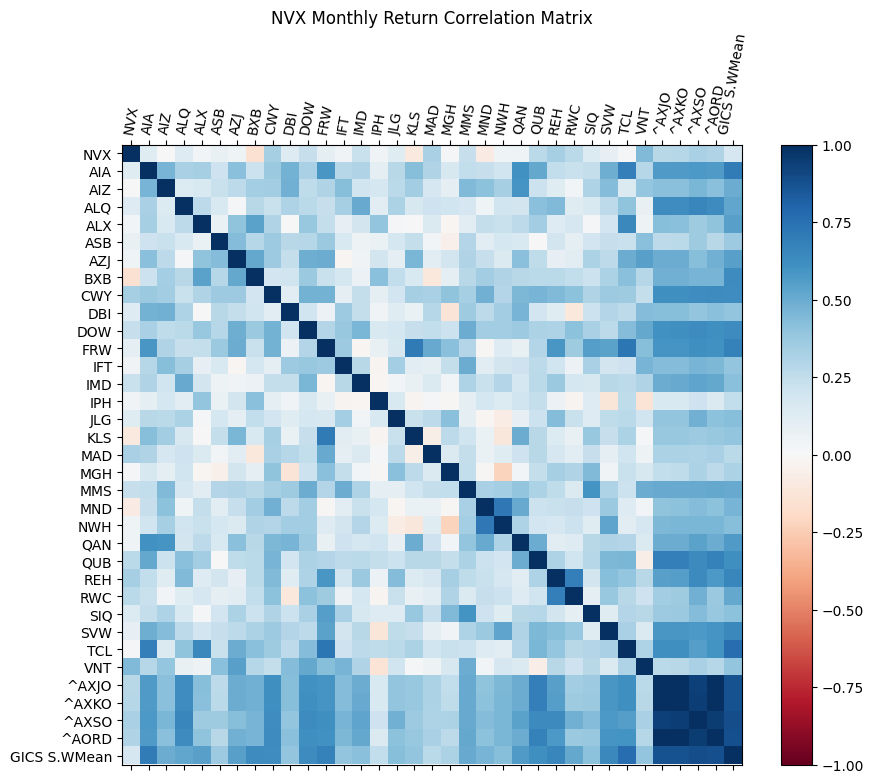

In [26]:
plot_correlation(correlation_df, ticker=TICKER)

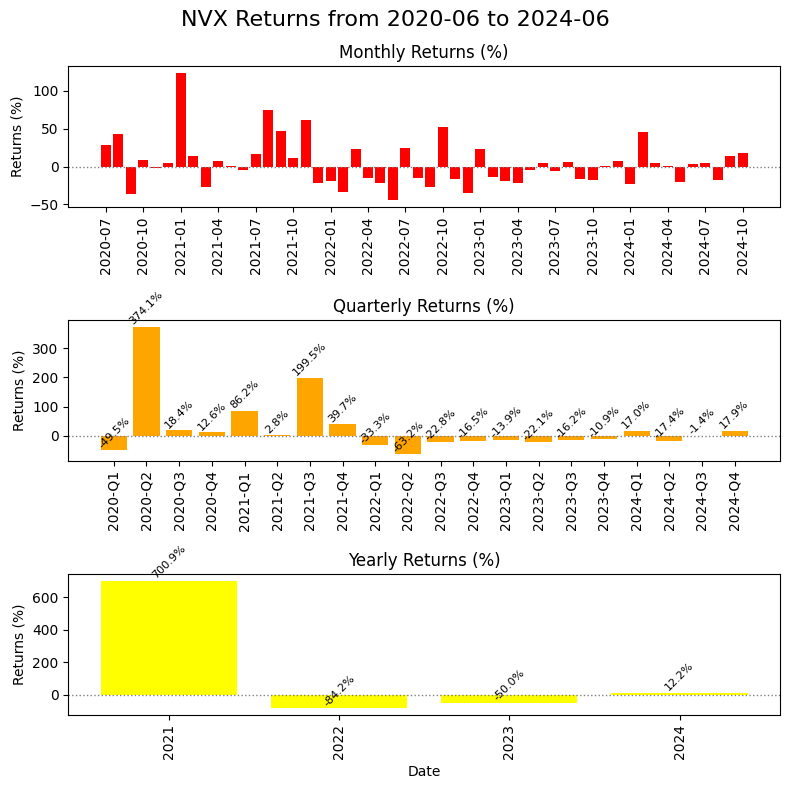

In [27]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'ticker': TICKER,
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

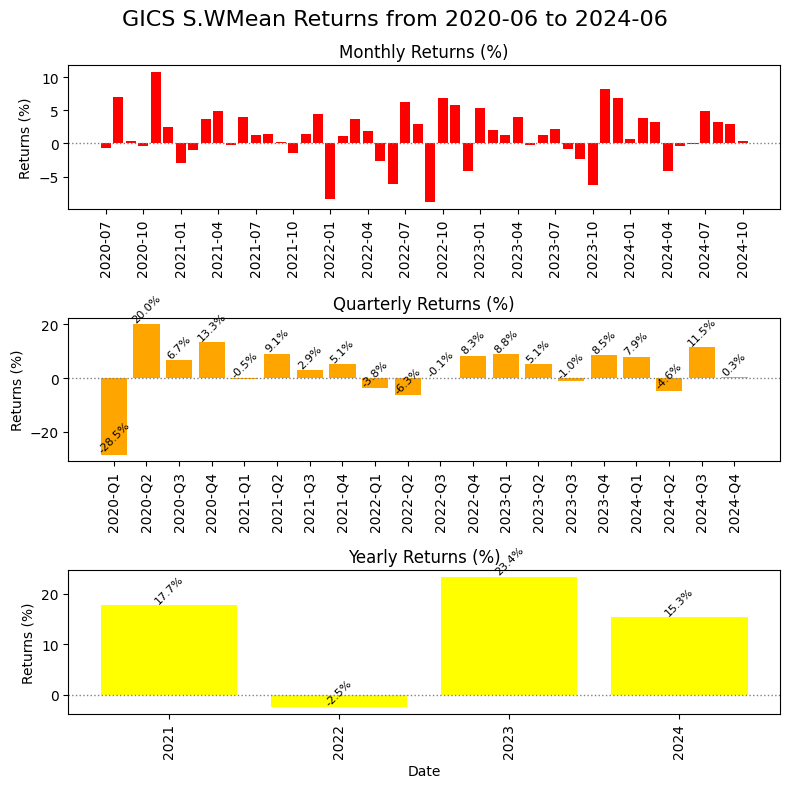

In [28]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict,
                'ticker': 'GICS I.WMean' if 'industry' in comparable_tickers['type'] else 'GICS S.WMean',
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter,
                'underlying_ticker': TICKER})

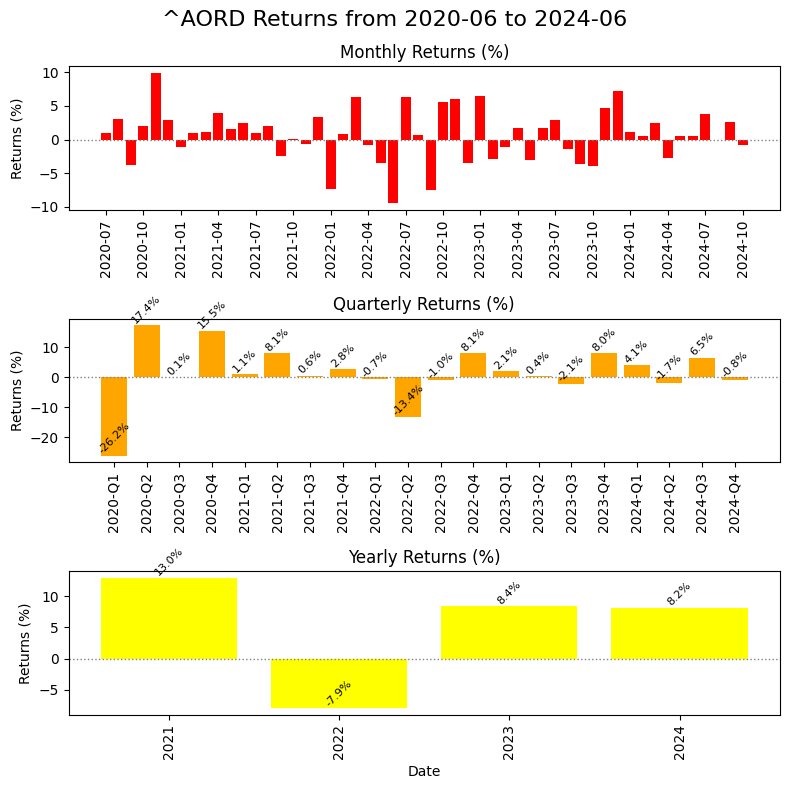

In [29]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'ticker': '^AORD',
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

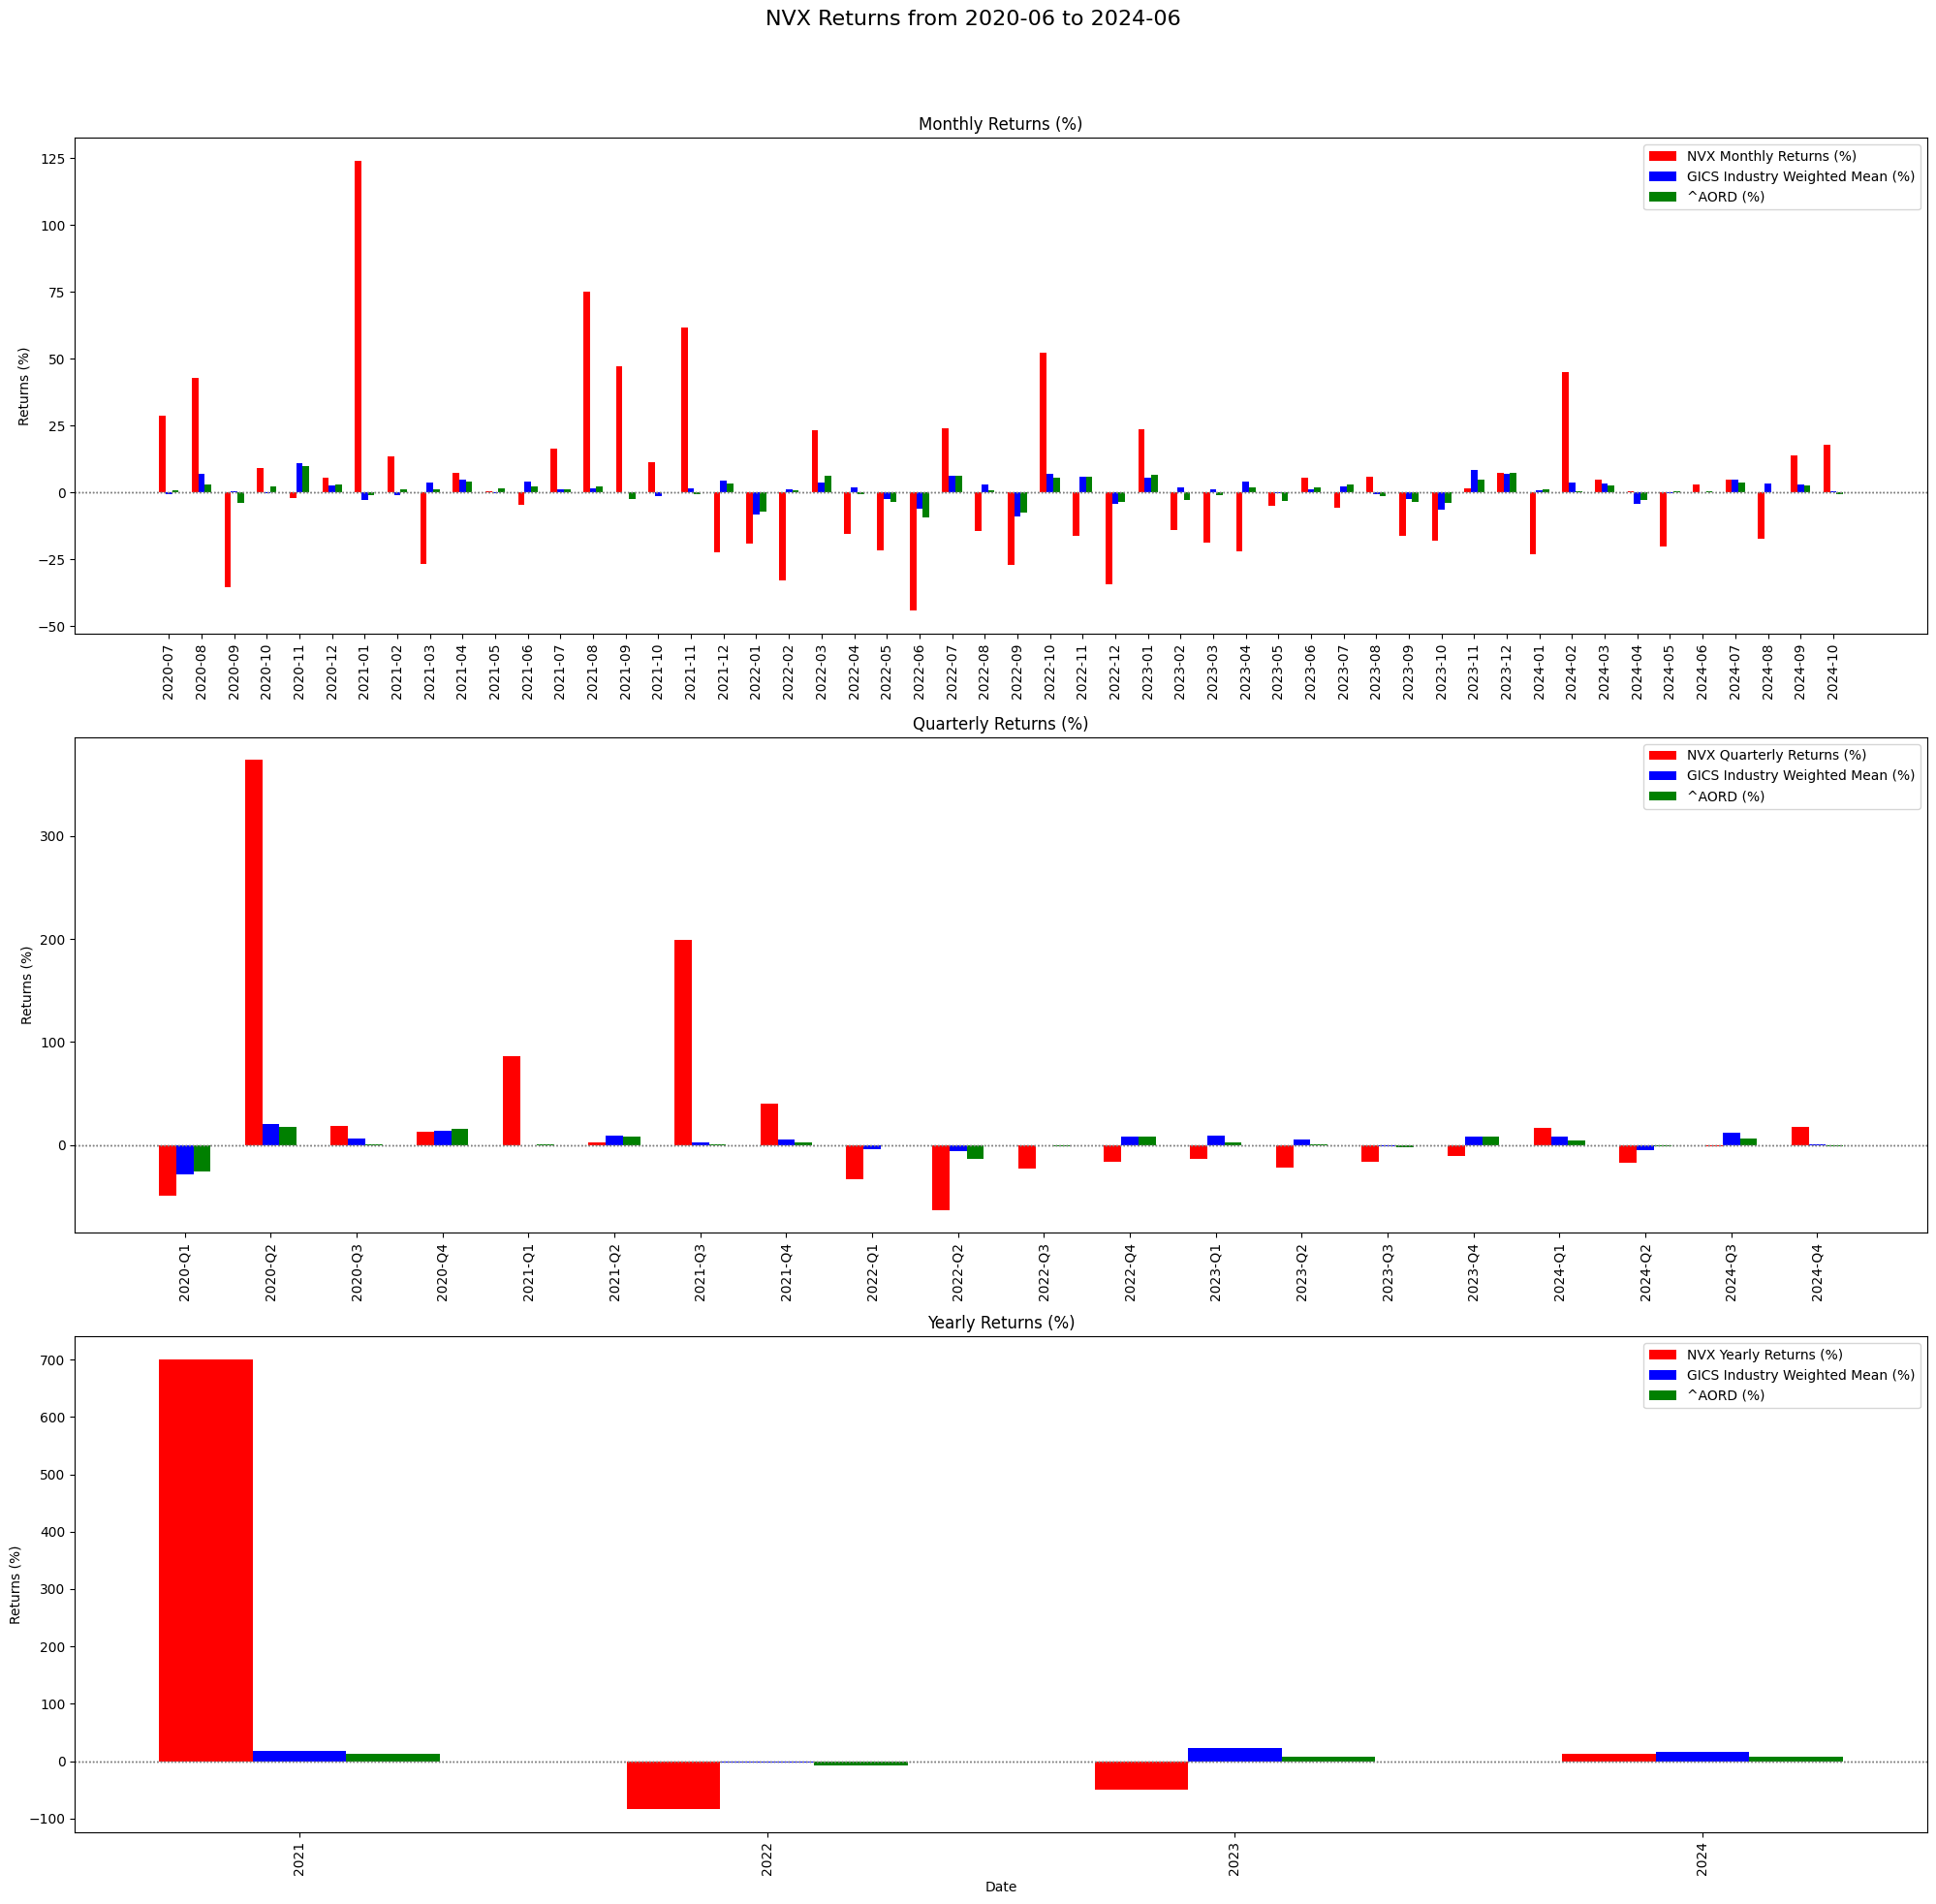

In [30]:
plot_returns_comparative(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                            'quarterly_returns_df_dict': quarterly_returns_df_dict,
                            'yearly_returns_df_dict': yearly_returns_df_dict, 'TICKER': TICKER,
                            'first_end_of_quarter': first_end_of_quarter,
                            'last_end_of_quarter': last_end_of_quarter,
                            'comparable_tickers': comparable_tickers})

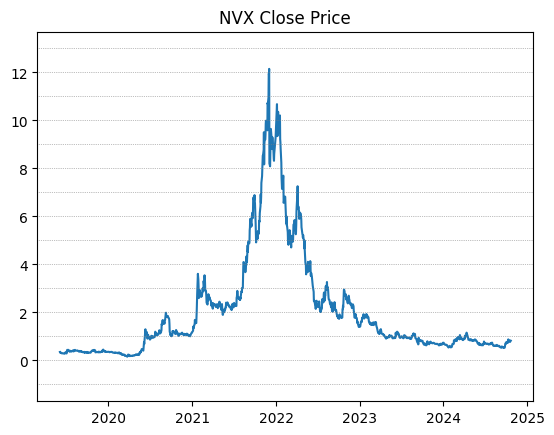

In [31]:
plot_close_price_with_dollar_lines(TICKER, historical_prices)

In [32]:
# Convert date to AEST directly using tz_convert, since the index is already timezone-aware
historical_dividends = historical_prices[TICKER]

# Reset index to move 'Date' from index to a column
historical_dividends = historical_dividends.reset_index()

# Ensure the 'Date' column is in datetime format
historical_dividends['Date'] = pd.to_datetime(historical_dividends['Date'])

# Convert the 'Date' column to AEST
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_convert(
    'Australia/Sydney')

# Now make it timezone unaware but still a timestamp
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_localize(
    None)

# Display the dividends greater than 0 with the adjusted 'Date' column
display(historical_dividends[historical_dividends['Dividends'] > 0][[
        'Date', 'Dividends']])

,Date,Dividends


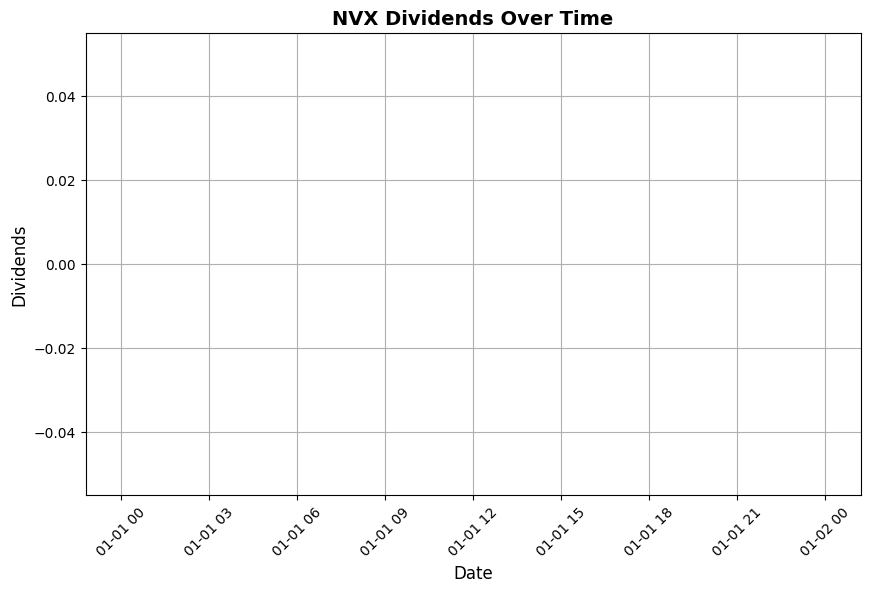

In [33]:
# Assuming historical_dividends is your DataFrame for a specific TICKER
# Convert the date to AEST
historical_dividends = historical_prices[TICKER]
# Reset index to move 'Date' from index to a column
historical_dividends = historical_dividends.reset_index()
historical_dividends['Date'] = pd.to_datetime(historical_dividends['Date'])
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_convert(
    'Australia/Sydney')
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_localize(
    None)

# Filter the data to include only the rows where Dividends are greater than 0
dividends_df = historical_dividends[historical_dividends['Dividends'] > 0][[
    'Date', 'Dividends']]

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))  # Create a plot with a defined size

# Plot Date vs Dividends
ax.plot(dividends_df['Date'], dividends_df['Dividends'],
        marker='o', linestyle='-', color='b')

# Set the title and labels
ax.set_title(f'{TICKER} Dividends Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Dividends', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
ax.grid(True)

# Save the plot as an image if needed
plt.savefig(f'../outputs/{TICKER}_dividends_over_time.png',
            bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

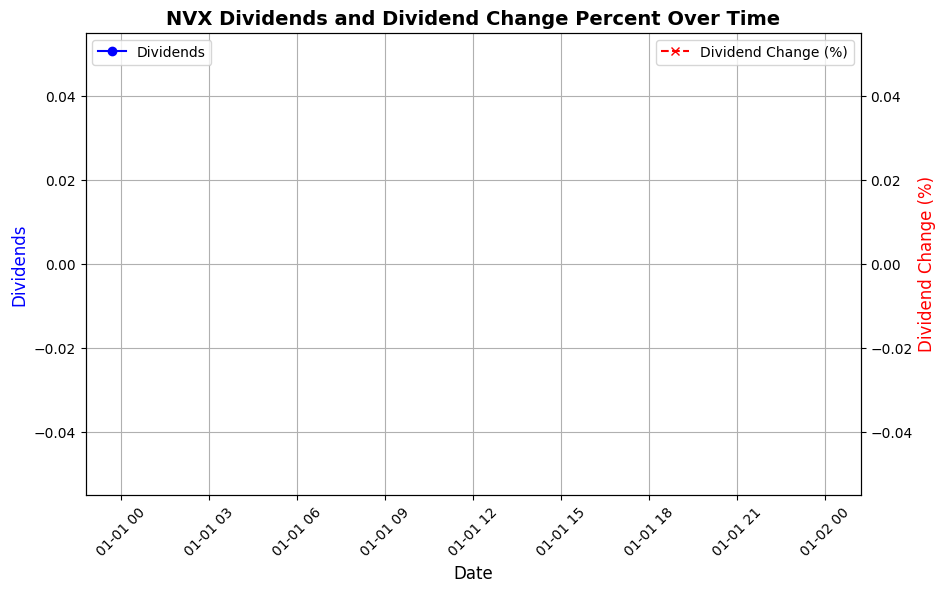

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming historical_dividends is your DataFrame for a specific TICKER
# Convert the date to AEST
historical_dividends = historical_prices[TICKER]

# Reset index to move 'Date' from index to a column
historical_dividends = historical_dividends.reset_index()
historical_dividends['Date'] = pd.to_datetime(historical_dividends['Date'])
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_convert(
    'Australia/Sydney')
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_localize(
    None)

# Filter the data to include only the rows where Dividends are greater than 0
dividends_df = historical_dividends[historical_dividends['Dividends'] > 0][[
    'Date', 'Dividends']]

# Calculate the percentage change in dividends
dividends_df['Dividend Change (%)'] = dividends_df['Dividends'].pct_change(
) * 100

# Plot the data
fig, ax1 = plt.subplots(figsize=(10, 6))  # Create a plot with a defined size

# Plot Date vs Dividends on the primary y-axis
ax1.plot(dividends_df['Date'], dividends_df['Dividends'],
         marker='o', linestyle='-', color='b', label='Dividends')

# Set the title and labels for the primary y-axis
ax1.set_title(f'{TICKER} Dividends and Dividend Change Percent Over Time',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Dividends', fontsize=12, color='b')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
ax1.grid(True)

# Create a secondary y-axis to plot the dividend change percentage
ax2 = ax1.twinx()

# Plot Date vs Dividend Change (%) on the secondary y-axis
ax2.plot(dividends_df['Date'], dividends_df['Dividend Change (%)'],
         marker='x', linestyle='--', color='r', label='Dividend Change (%)')

# Set the labels for the secondary y-axis
ax2.set_ylabel('Dividend Change (%)', fontsize=12, color='r')

# Add legends to distinguish between the two y-axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Annotate the percentage change values on the plot
for i, (date, change) in dividends_df[['Date', 'Dividend Change (%)']].dropna().iterrows():
    ax2.annotate(f'{change:.1f}%', xy=(date, change), xytext=(5, 5),
                 textcoords='offset points', fontsize=10, color='r')

# Save the plot as an image if needed
plt.savefig(
    f'../outputs/{TICKER}_dividends_and_change_over_time.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [35]:
# Convert date to AEST directly using tz_convert, since the index is already timezone-aware
historical_splits = historical_prices[TICKER]

# Reset index to move 'Date' from index to a column
historical_splits = historical_splits.reset_index()

# Ensure the 'Date' column is in datetime format
historical_splits['Date'] = pd.to_datetime(historical_splits['Date'])

# Convert the 'Date' column to AEST
historical_splits['Date'] = historical_splits['Date'].dt.tz_convert(
    'Australia/Sydney')

# Now make it timezone unaware but still a timestamp
historical_splits['Date'] = historical_splits['Date'].dt.tz_localize(
    None)

# Display the dividends greater than 0 with the adjusted 'Date' column
display(historical_splits[historical_splits['Stock Splits'] > 0][[
        'Date', 'Stock Splits']])

,Date,Stock Splits


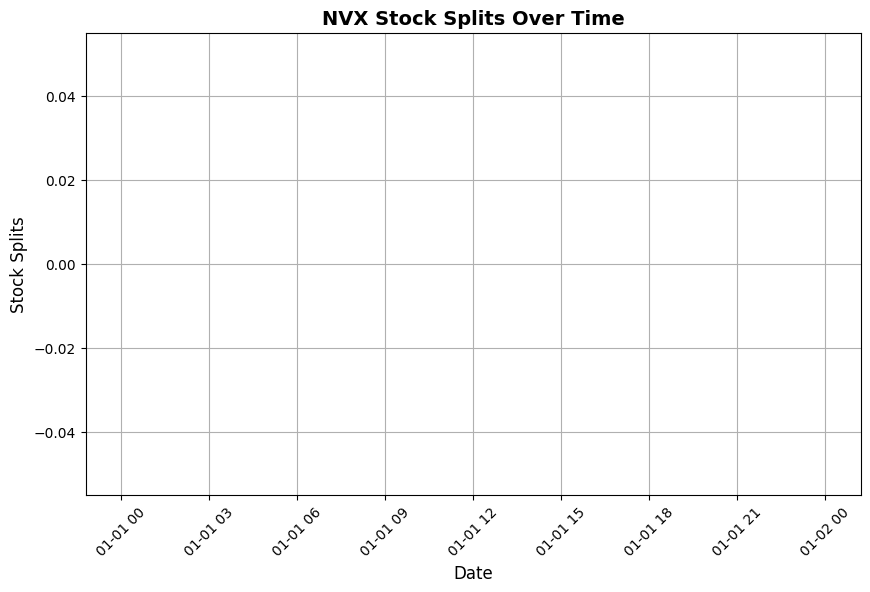

In [36]:
# Assuming historical_splits is your DataFrame for a specific TICKER
# Convert the date to AEST
historical_splits = historical_prices[TICKER]

# Reset index to move 'Date' from index to a column
historical_splits = historical_splits.reset_index()

# Ensure the 'Date' column is in datetime format
historical_splits['Date'] = pd.to_datetime(historical_splits['Date'])

# Convert the 'Date' column to AEST
historical_splits['Date'] = historical_splits['Date'].dt.tz_convert(
    'Australia/Sydney')

# Now make it timezone-unaware but still a timestamp
historical_splits['Date'] = historical_splits['Date'].dt.tz_localize(None)

# Filter the data to include only the rows where Stock Splits are greater than 0
splits_df = historical_splits[historical_splits['Stock Splits'] > 0][[
    'Date', 'Stock Splits']]

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))  # Create a plot with a defined size

# Plot Date vs Stock Splits
ax.plot(splits_df['Date'], splits_df['Stock Splits'],
        marker='o', linestyle='-', color='b')

# Set the title and labels
ax.set_title(f'{TICKER} Stock Splits Over Time',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Stock Splits', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
ax.grid(True)

# Save the plot as an image if needed
plt.savefig(f'../outputs/{TICKER}_stock_splits_over_time.png',
            bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

- beta: need interest rate

In [37]:
# pdf = FPDF()

# # TITLE
# # Add a page
# pdf.add_page()
# # Set font for the title
# pdf.set_font("Arial", 'B', 16)  # Bold and size 16 for the title
# title = f"Stock Analysis of Ticker: {TICKER}"
# pdf.cell(200, 10, txt=title, ln=True, align='C')

# # Comparable Ticker Universe
# # Set font for the content
# pdf.set_font("Arial", 'B', size=12)
# pdf.cell(200, 10, txt=f"Comparable tickers universe", ln=True, align='L')
# pdf.set_font("Arial", size=10)
# text = f"{'same INDUSTRY of TOP500' if 'industry' in comparable_tickers['type'] else 'same SECTOR of MCAP$1BN+'}"
# pdf.cell(200, 10, txt=text, ln=True, align='L')

# # Retrieve and convert the Market Cap of the stock in question (from ticker_mv) to billions
# ticker_market_cap_billion = round(
#     ticker_mv.iloc[0]['Market Cap ($bn)'], 2)
# ticker_proportion_of_market = ticker_mv['Market Cap ($bn)'].values[0] / \
#     same_industry_tickers_mcap['Market Cap ($bn)'].sum()
# universe_market_value_billion = round(
#     same_industry_tickers_mcap['Market Cap ($bn)'].sum(), 2)
# pdf.cell(
#     200, 10, txt=f"{TICKER} has a market value of ${ticker_market_cap_billion}B and is {round(ticker_proportion_of_market, 2)} times the universe market value of ${universe_market_value_billion}B,", align='L')
# pdf.cell(
#     200, 10, txt=f"{round(ticker_mv['Market Cap ($bn)'].values[0]/weighted_mean_df['Market Cap ($bn)'].values[0],2)} times the average stock MCap in the universe.", align='L')
# pdf.ln()

# # KEY STATS
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Key Stats", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(
#     f'../outputs/{TICKER}_key_ticker_stats_table.png', x=10, y=None, w=125)

# # COMPARATIVE RETURNS PLOTS
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Comparative Returns Plot", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_comparative_returns.png', x=10, y=None, w=150)

# # TICKER RETURN CHART
# pdf.add_page()  # Add a new page for the plot
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Returns Chart", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_returns.png', x=10, y=None, w=100)

# # SECTOR/INDUSTRY WMEAN RETURNS CHART
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(
#     200, 10, txt=f"{TICKER} {'Industry' if 'industry' in comparable_tickers['type'] else 'Sector'} Weighted Mean Returns Chart", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_WMean_returns.png', x=10, y=None, w=100)

# # ^AORD CHART
# pdf.add_page()
# pdf.set_font("Arial", 'B', 12)
# pdf.cell(
#     200, 10, txt=f"{TICKER} ^AORD Chart", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/^AORD_returns.png', x=10, y=None, w=100)

# # CLOSE PRICE CHART
# pdf.add_page()  # Add a new page for the plot
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Close Price Chart", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_close_price.png', x=10, y=None, w=75)

# # DIVIDENDS
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Dividends", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_dividends_over_time.png', x=10, y=None, w=75)

# # APPENDIX
# pdf.add_page()  # Add a new page for the appendix
# # Set font for the title
# pdf.set_font("Arial", 'B', 12)  # Bold and size 16 for the title

# # APPENDIX TITLE
# title = f"Appendix"
# pdf.cell(200, 10, txt=title, ln=True, align='C')

# # CORRELATION
# pdf.set_font("Arial", 'B', 12)
# pdf.cell(200, 10, txt=f"{TICKER} Correlation Matrix Plot", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_correlation_matrix.png', x=10, y=None, w=140)

# # SPLITS
# pdf.set_font("Arial", 'B', 12)
# pdf.cell(200, 10, txt=f"{TICKER} Splits", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(
#     f'../outputs/{TICKER}_stock_splits_over_time.png', x=10, y=None, w=75)

# # INDUSTRY TICKER MCAP TABLE
# pdf.add_page()
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(
#     200, 10, txt=f"{TICKER} Same {'Industry' if 'industry' in comparable_tickers['type'] else 'Sector'} Ticker MCAP Table", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(
#     f'../outputs/{TICKER}_same_industry_tickers_mcap_table.png', x=10, y=None, w=75)

# # Save the PDF after adding the image
# pdf.output(f"../reports/{TICKER}_comparable_tickers_report_with_plot.pdf")

# Other Stats

In [38]:
interested_ticker_raw_stats, interested_ticker_key_interested_stats, interested_ticker_key_interested_stats_pct_change = get_fundemental_dfs(first_end_of_quarter, historical_prices, TICKER)

Income Tax Paid Supplemental Data not found for ticker NVX
Missing data for Net Profit for ticker NVX


In [39]:
interested_ticker_raw_stats

,Total Debt,Stockholders Equity,Share Issued,Current Liabilities,Current Assets,Free Cash Flow,Interest Paid Supplemental Data,EBITDA,EBIT,Gross Profit,Operating Expense,Net Income,Total Revenue,Interest Expense,Net Profit,Average Shareholder Equity,Total Asset,Last Close Price,Dividends
2020-06-30,NaN,NaN,NaN,NaN,NaN,-7426208.0,232055.0,-9889331.0,-11072623.0,2016403.0,11480306.0,-13430174.0,2851035.0,2357551.0,NaN,NaN,NaN,0.870,NaN
2021-06-30,10356322.0,138449834.0,404601384.0,4019887.0,108227852.0,-25664712.0,227789.0,-12041303.0,-13305925.0,3083075.0,14332336.0,-13446593.0,3893739.0,140668.0,NaN,138449834.0,142469721.0,2.220,0.0
2022-06-30,42309006.0,251133478.0,485951369.0,7890475.0,162223451.0,-113019442.0,NaN,-46177118.0,-50391738.0,4376530.0,52419783.0,-51860307.0,6101155.0,1468569.0,NaN,194791656.0,259023953.0,2.280,0.0
2022-12-31,41341840.0,226056269.0,486774622.0,8465141.0,116148207.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,238594873.5,234521410.0,1.470,0.0
2023-12-31,69387750.0,183936275.0,488733461.0,7840362.0,89153275.0,-55424219.0,NaN,-38862526.0,-43602661.0,5237259.0,53465364.0,-46248261.0,8054528.0,2845549.0,NaN,204996272.0,191776637.0,0.735,0.0


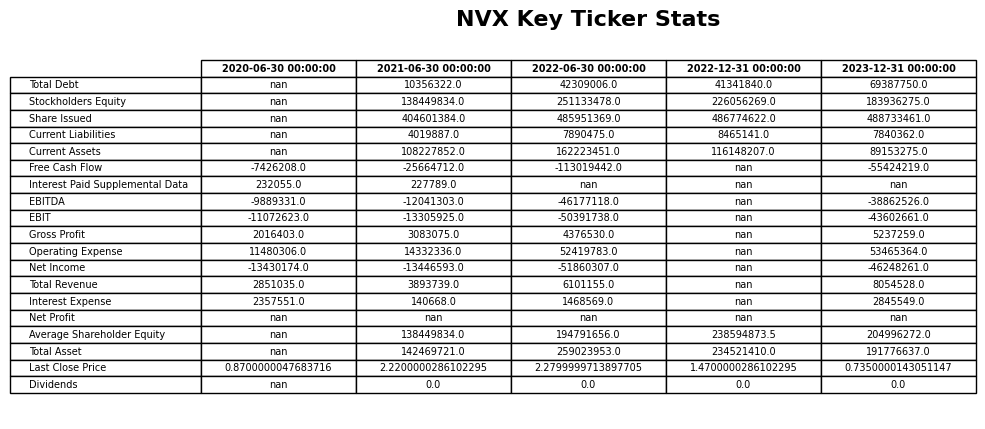

In [40]:
# Create the plot for the table
fig, ax = plt.subplots(figsize=(10, 5))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=interested_ticker_raw_stats.T.values,
                 colLabels=interested_ticker_raw_stats.T.columns,
                 rowLabels=interested_ticker_raw_stats.T.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Key Ticker Stats", fontsize=16, fontweight='bold')

# Save the plot as an image
plt.savefig(f'../outputs/{TICKER}_interested_ticker_raw_stats.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [41]:
interested_ticker_key_interested_stats

,Net Profit Margin,Net Income Margin,RoE,RoA,P/E,P/B,D/E,Current Ratio,Interest Coverage Ratio,DPS
2020-06-30,NaN,-4.71,NaN,NaN,NaN,NaN,NaN,NaN,-47.72,NaN
2021-06-30,NaN,-3.45,NaN,NaN,-66.80,6.49,0.07,26.92,-58.41,0.0
2022-06-30,NaN,-8.50,NaN,NaN,-21.36,4.41,0.17,20.56,NaN,0.0
2022-12-31,NaN,NaN,NaN,NaN,NaN,3.17,0.18,13.72,NaN,0.0
2023-12-31,NaN,-5.74,NaN,NaN,-7.77,1.95,0.38,11.37,NaN,0.0


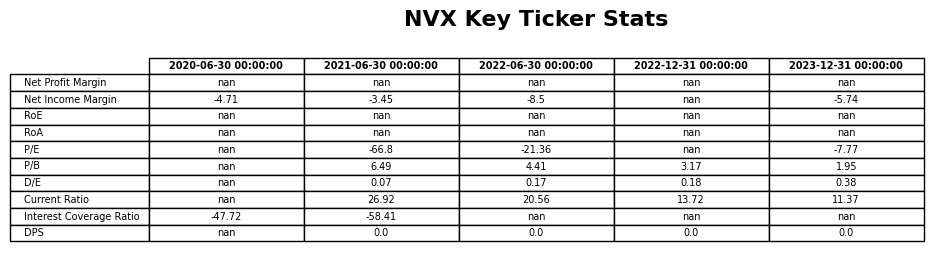

In [42]:
# Create the plot for the table
fig, ax = plt.subplots(figsize=(10, 3))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=interested_ticker_key_interested_stats.T.values,
                 colLabels=interested_ticker_key_interested_stats.T.columns,
                 rowLabels=interested_ticker_key_interested_stats.T.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Key Ticker Stats", fontsize=16, fontweight='bold')

# Save the plot as an image
plt.savefig(f'../outputs/{TICKER}_interested_ticker_key_interested_stats.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [43]:
interested_ticker_key_interested_stats_pct_change

,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,-26.69,NaN,NaN,NaN,NaN,NaN,NaN,22.42,NaN
2022-06-30,NaN,146.14,NaN,NaN,-68.02,-32.00,125.22,-23.64,0.00,NaN
2022-12-31,NaN,0.00,NaN,NaN,0.00,-28.25,8.55,-33.26,0.00,NaN
2023-12-31,NaN,-32.45,NaN,NaN,-63.64,-38.30,106.27,-17.13,0.00,NaN


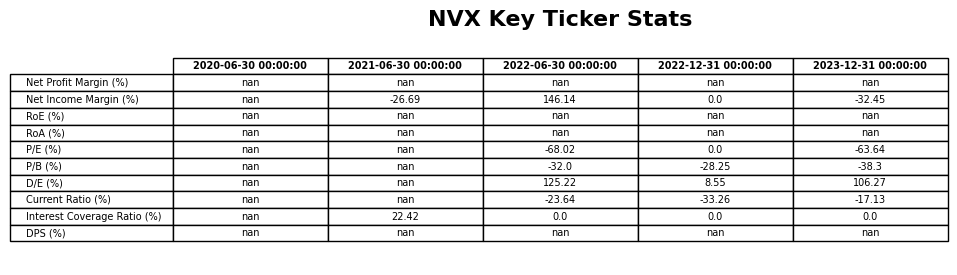

In [44]:
# Create the plot for the table
fig, ax = plt.subplots(figsize=(10, 3))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=interested_ticker_key_interested_stats_pct_change.T.values,
                 colLabels=interested_ticker_key_interested_stats_pct_change.T.columns,
                 rowLabels=interested_ticker_key_interested_stats_pct_change.T.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Key Ticker Stats", fontsize=16, fontweight='bold')

# Save the plot as an image
plt.savefig(f'../outputs/{TICKER}_interested_ticker_key_interested_stats_pct_change.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [53]:
key_interested_stats_pct_change_list = dict()

for ticker in tqdm(comparable_tickers['list']):
    ticker = ticker.split('.')[0]
    raw_stats, key_interested_stats, key_interested_stats_pct_change = get_fundemental_dfs(
        first_end_of_quarter, historical_prices, ticker)
    
    key_interested_stats_pct_change_list[ticker] = key_interested_stats_pct_change

 17%|█▋        | 5/29 [00:05<00:26,  1.10s/it]

Interest Paid Supplemental Data not found for ticker AZJ
Missing data for Net Profit for ticker AZJ


 21%|██        | 6/29 [00:06<00:24,  1.05s/it]

Missing data for Interest Coverage Ratio for ticker AZJ


 83%|████████▎ | 24/29 [00:24<00:05,  1.06s/it]

Interest Paid Supplemental Data not found for ticker RWC
Missing data for Net Profit for ticker RWC


 86%|████████▌ | 25/29 [00:25<00:03,  1.03it/s]

Missing data for Interest Coverage Ratio for ticker RWC


100%|██████████| 29/29 [00:28<00:00,  1.00it/s]


In [55]:
for key in key_interested_stats_pct_change_list:
    print(key)
    display(key_interested_stats_pct_change_list[key])

AIA


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,0.00,-62.27,0.00,0.00,132.27,-6.69,3.19,-68.23,-27.64,NaN
2023-06-30,0.00,-89.25,0.00,0.00,437.32,17.87,19.73,119.99,-57.42,NaN
2024-06-30,-200.52,-91.00,-404.85,-393.79,619.56,-10.86,43.76,98.65,230.62,inf


AIZ


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,0.00,88.27,0.00,0.00,-48.79,-30.99,-32.93,124.32,2401.81,NaN
2023-06-30,-144.68,-130.11,-166.12,-165.70,-303.10,14.21,-20.13,8.22,-105.26,NaN
2024-06-30,-95.15,-66.78,-95.25,-94.55,112.98,-21.93,-12.66,-20.44,-55.22,inf


ALQ


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-31,-8.12,-7.80,7.41,-14.37,28.89,35.77,22.06,-46.23,16.32,108.22
2023-03-31,57.79,41.41,50.13,60.14,-37.77,-22.05,-4.11,41.45,13.73,22.70
2024-03-31,-33.78,-95.90,-30.25,-30.42,2378.32,26.82,49.30,-1.79,-68.47,4.56


ALX


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31,NaN,-405.11,NaN,NaN,-138.04,14.34,9.36,-39.44,NaN,159.09
2022-12-31,NaN,39.05,NaN,NaN,-5.48,-16.93,-43.29,91.58,0.0,47.03
2023-12-31,NaN,6.19,NaN,NaN,-22.94,79.83,90.93,-32.62,0.0,2.15


ASB


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,15.82,7.99,-4.04,-4.33,-6.47,-23.11,-4.17,6.82,-7.28,-11.11
2023-06-30,-381.88,-115.61,-383.48,-376.52,-890.52,33.31,0.05,-26.20,-101.03,0.00
2024-06-30,67.19,-216.54,48.57,31.76,-198.94,0.91,10.39,-18.48,-1392.10,-62.50


AZJ


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,NaN,-30.58,NaN,NaN,55.29,5.68,-16.41,-21.40,NaN,-11.39
2023-06-30,NaN,-53.12,NaN,NaN,101.39,9.83,56.47,2.35,NaN,-28.11
2024-06-30,NaN,34.65,NaN,NaN,-33.67,-4.29,-6.48,-36.95,NaN,-1.12


BXB


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,-20.05,5.69,-10.74,-15.20,-17.98,1.48,28.08,-19.27,7.98,14.36
2023-06-30,12.86,8.44,19.18,-1.27,16.97,18.42,-14.33,-18.16,-17.52,19.18
2024-06-30,18.31,2.95,11.22,35.94,-6.12,-7.42,-18.57,26.00,6.58,28.64


CWY


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,-44.73,-56.64,-30.68,-37.49,79.14,-2.41,57.39,-17.98,-44.59,10.34
2023-06-30,-67.91,-76.82,-64.20,-64.93,312.68,0.83,-15.77,12.79,-56.87,2.08
2024-06-30,366.93,587.13,361.80,371.63,-84.94,7.13,6.95,-3.83,121.70,0.00


DBI


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31,NaN,-58.11,NaN,NaN,145.28,19.54,-13.47,-35.61,-15.57,NaN
2023-12-31,NaN,3.50,NaN,NaN,11.64,25.95,22.21,46.55,-14.03,9.59


DOW


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,-67.82,-12.35,-68.72,-65.50,9.41,-4.83,-7.32,7.84,17.98,166.67
2023-06-30,26.19,-339.77,51.23,44.32,-133.06,4.10,38.52,6.62,-179.90,-29.17
2024-06-30,-8.62,-119.00,0.99,-6.02,-750.53,28.25,-6.84,-3.95,-161.93,-17.65


FRW


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,1.48,29.69,8.25,-5.17,NaN,NaN,-2.08,-13.18,36.08,NaN
2023-06-30,-8.49,-16.55,-1.52,-0.35,NaN,NaN,0.86,36.23,-22.79,NaN
2024-06-30,-21.07,-12.65,-26.82,-19.15,NaN,NaN,-4.18,-8.64,-18.67,inf


IFT


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-31,4.81,-3030.31,-29.30,-24.00,-104.99,-15.63,-27.49,-30.34,519.20,1.23
2023-03-31,-61.92,-60.36,-57.60,-52.71,116.07,4.88,-18.60,-14.92,203.45,3.33
2024-03-31,-261.57,-47.17,-417.67,-390.56,0.65,-4.98,43.74,-32.75,-43.51,2.45


IMD


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,13.85,9.19,35.39,30.52,-35.20,-22.10,-20.28,14.86,17.36,70.58
2023-06-30,0.00,-34.96,0.00,0.00,69.66,-29.04,84.17,-20.17,0.00,18.06
2024-06-30,0.00,-14.46,0.00,0.00,30.85,17.94,-22.97,-12.93,0.00,6.82


IPH


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,-5.30,-5.77,-1.77,-3.88,11.16,8.27,0.46,3.34,28.41,3.45
2023-06-30,-6.86,-4.81,2.21,-9.58,-13.14,-20.59,103.80,13.61,-68.32,5.00
2024-06-30,-22.46,-24.89,-19.17,-11.93,-5.99,-19.42,1.40,-13.11,-27.00,6.35


JLG


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,-6.14,-14.06,-49.73,-47.25,-2.94,-73.09,-65.45,2.16,18.64,25.08
2023-06-30,16.49,30.29,-5.28,46.91,-49.14,-15.39,35.16,8.54,-0.29,36.45
2024-06-30,-5.89,13.32,-28.66,-19.00,12.51,-8.28,-28.77,1.54,-30.36,22.67


KLS


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,-483.81,23.96,-522.32,-503.46,-56.18,-41.72,15.42,23.06,16.82,39.13
2023-06-30,-10.09,-62.92,-23.18,-26.12,307.31,12.02,-1.00,17.71,-42.67,6.25
2024-06-30,-19.21,94.19,-2.92,10.27,-73.50,-27.10,25.96,-7.76,-8.12,4.33


MAD


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,-2.23,9.34,7.62,-7.62,121.38,128.35,-3.80,-4.75,6.89,16.67
2023-06-30,36.17,-8.99,46.75,60.43,57.50,54.16,10.08,30.36,-46.79,25.71
2024-06-30,-15.67,2.92,-21.59,-26.63,-14.80,-16.75,-19.22,-10.69,2.42,63.64


MGH


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,-25.72,-4.61,-0.67,-22.72,-59.03,-59.29,17.18,12.66,4.09,150.00
2023-06-30,-59.11,-30.85,-58.48,-54.18,-23.51,-40.44,20.35,-6.76,-64.31,30.00
2024-06-30,79.73,-2.37,69.05,83.22,47.08,50.41,6.08,-7.54,-19.33,-7.69


MMS


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,-229.91,47.24,-197.62,-204.62,-31.07,-26.65,-10.24,24.16,17.71,115.56
2023-06-30,-41.87,-44.22,-38.66,-70.02,299.89,267.24,197.41,-46.70,-8.19,102.76
2024-06-30,-120.23,117.97,-138.26,-123.55,-59.64,18.04,104.38,4.03,-42.52,7.58


MND


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,-62.15,7.55,-61.75,-62.27,-10.15,-4.32,7.66,1.82,-3.82,21.62
2023-06-30,-85.55,7.81,-86.94,-86.00,20.86,16.62,-23.73,2.55,-3.99,8.89
2024-06-30,594.77,-0.46,662.95,595.36,-1.15,8.03,-0.09,-17.80,15.39,2.04


NWH


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,NaN,67.63,NaN,NaN,-31.80,11.48,-18.04,-5.88,75.39,31.25
2023-06-30,-7.16,-21.63,-1.46,2.57,82.39,57.23,6.98,-3.11,-31.18,47.62
2024-06-30,-35.14,12.36,-32.21,-34.49,5.83,21.43,-2.44,3.30,-0.94,-6.45


QAN


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,NaN,-67.27,NaN,NaN,92.74,-349.79,-328.86,18.14,-57.87,NaN
2023-06-30,-146.91,-190.48,73.22,-190.11,-162.47,-5096.66,-3764.33,-20.90,-417.64,NaN
2024-06-30,-34.36,-35.09,-147.47,-26.89,19.38,-98.52,-98.30,-19.71,-17.82,NaN


QUB


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,-884.03,8.74,-1161.80,-1151.95,-41.51,-8.55,-2.23,-62.74,-1894.06,35.42
2023-06-30,-218.98,15.10,-243.48,-228.38,-19.59,4.40,2.92,-36.23,1.40,-31.54
2024-06-30,-112.46,15.57,-113.97,-114.75,-0.36,28.33,11.75,51.05,-13.04,87.64


REH


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,-77.04,12.59,-73.92,-75.69,-57.07,-48.70,-17.49,-10.61,39.54,62.50
2023-06-30,-15.00,-14.49,-12.25,-7.00,38.54,25.32,-5.57,5.90,-23.48,17.95
2024-06-30,-38.87,4.99,-41.76,-40.75,26.87,28.06,-12.82,-4.28,-6.38,8.70


RWC


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,NaN,-16.48,NaN,NaN,-18.72,-16.48,312.77,58.42,NaN,56.29
2023-06-30,NaN,-4.25,NaN,NaN,3.75,-3.21,-26.46,-5.76,NaN,2.61
2024-06-30,NaN,-21.25,NaN,NaN,42.54,9.49,-1.95,-8.45,NaN,-17.79


SIQ


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31,59.34,38.81,64.80,62.94,-18.36,18.24,4.52,1.84,90.28,88.24
2022-12-31,-17.52,-1.34,-11.40,-8.88,-30.08,-22.59,87.23,-11.16,-37.94,12.50
2023-12-31,-10.48,-5.93,4.89,-1.48,68.89,75.37,10.68,11.65,-44.48,-18.06


SVW


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,-73.94,-46.63,-53.97,-62.02,-5.59,-4.76,131.35,35.03,-49.48,4.55
2023-06-30,309.52,-11.06,401.10,404.46,41.92,37.64,-19.49,19.19,28.92,0.00
2024-06-30,0.78,-29.42,3.65,-2.09,119.10,63.08,-2.77,-19.88,-9.98,0.00


TCL


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2020-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-30,-53.36,-99.51,-54.00,-58.79,20179.50,-16.27,-28.98,-56.69,36.99,13.27
2023-06-30,-271.37,175.99,-291.93,-336.82,-69.22,18.92,20.64,11.79,77.83,41.46
2024-06-30,33.20,414.07,50.89,41.68,-82.03,4.29,21.08,-1.05,22.11,6.90


VNT


,Net Profit Margin (%),Net Income Margin (%),RoE (%),RoA (%),P/E (%),P/B (%),D/E (%),Current Ratio (%),Interest Coverage Ratio (%),DPS (%)
2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-31,-892.98,764.37,NaN,-876.95,-87.41,-7.48,-25.73,13.18,533.66,NaN
2023-12-31,-3.69,-9.63,-11.63,3.45,40.20,27.14,-8.45,14.46,-20.10,85.57
